In [9]:
from collections import OrderedDict
from itertools import chain
from typing import List, Tuple

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from task import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 5: Graph Neural Networks

Given the citation network `Cora ML` we are going to perform semi-supervised node classification (*transductive learning*), i.e. predict the category for each node given a few labels. Each node represents one publication and each edge a citation. The features represent the bag of words of the respective abstract after stemming and stop word removal. These papers are classified into one of the following seven classes:
- Case Based
- Genetic Algorithms
- Neural Networks
- Probabilistic Methods
- Reinforcement Learning
- Rule Learning
- Theory

## General remarks

Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Below we list the allowed packages / no additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

*For scalability reasons, please do not transform sparse matrices to dense (e.g. using `.to_dense()`)*

### You are allowed to use the following methods/packages:

In [10]:
import torch
from torch import nn
from torch import sparse as sp
from torch.nn import functional as F

## Reproducibility
For better reproducibility than in the last task - [*still, it might not be perfect*](https://pytorch.org/docs/stable/notes/randomness.html) :-)

In [11]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Check if a GPU is available (or overwrite it with `False`)
You are allowed to edit this line if it better fits you needs (only to change the value `use_cuda` - *this will affect the results*). However, note that in Artemis you might now have a GPU available so do not include such code in your final submission.

In [12]:
use_cuda = torch.cuda.is_available() # = False

## Load data

* `N` = number of publications (nodes in the graph)
* `D` = number of features (bag of words one hot representation)
<!--* `C` = number of categories-->
* The graph is stored as a _sparse torch tensor_ `A` (shape `[N, N]`).
* The (binary) Features are stored in a _feature tensor_ `X` (shape `[N, D]`).
* The labels are stored in a _vector_ `y` (shape `[N]`).

In [13]:
X = torch.load('./X.pt')
N, D = X.shape

A_indices = torch.load('./A_indices.pt')
A = torch.sparse_coo_tensor(A_indices, torch.ones_like(A_indices[0]).float(), (N, N)).coalesce()
del A_indices

labels = torch.load('./labels.pt')
C = labels.max().item() + 1

if use_cuda:
    A, X, labels = A.cuda(), X.cuda(), labels.cuda()

A, X, labels, N, D, C

(tensor(indices=tensor([[   0,    0,    0,  ..., 2808, 2809, 2809],
                        [   0, 1579, 1581,  ..., 2808, 1399, 2809]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        size=(2810, 2810), nnz=18772, layout=torch.sparse_coo),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0, 1, 1,  ..., 4, 6, 3]),
 2810,
 2879,
 7)

## 1 - Graph Convolutional Network 

For the graph convolutional layer we are going to use the following update scheme:

$$H^{(l+1)}=\sigma\left(D^{-\frac{1}{2}} A D^{-\frac{1}{2}} H^{(l)} W{(l)}\right)$$

We use the ReLU for the activation function, but in the last layer where we directly output the raw logits (i.e. no activation at all). With $𝐻^{(0)}$ we denote the node features.


### 1.1 - Implementation

In this section your task is to implement a GCN in two steps. First we define the message passing / graph convolution module and then use this building block for a GCN.

#### 1.1.1 - Graph Convolution Layer / Message Passing 

Go to the class `GraphConvolution` in `task.py`.

We also denote the normalized adjacency matrix as $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$. Here you are supposed to implement:

$$Z^{(𝑙+1)}=\hat{A} 𝐻^{(𝑙)} 𝑊{(𝑙)}$$

#### 1.1.2 - Graph Convolution Network
Go to the class `GCN` in `task.py`.

This task to two-fold: (1) you need to calculate `A_hat` in `_normalize(...)` and (2) connect the building blocks in `forward(...)`.

In [14]:
three_layer_gcn = GCN(n_features=D, n_classes=C, hidden_dimensions=[64, 64])
if use_cuda:
    three_layer_gcn = three_layer_gcn.cuda()
    
three_layer_gcn

GCN(
  (propagate): ModuleList(
    (0): Sequential(
      (gcn_0): GraphConvolution(
        (_linear): Linear(in_features=2879, out_features=64, bias=False)
      )
      (activation_0): ReLU()
      (dropout_0): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (gcn_1): GraphConvolution(
        (_linear): Linear(in_features=64, out_features=64, bias=False)
      )
      (activation_1): ReLU()
      (dropout_1): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (gcn_2): GraphConvolution(
        (_linear): Linear(in_features=64, out_features=7, bias=False)
      )
    )
  )
)

### 1.2 - Training 
In the following we provide the `split` method for obtaining a train/validation/test-split. Subsequently, you will fill in the gap in the training loop (in `task.py`):
- Calculate the train and validation loss (we refer to slide 23 "How to Perform Semi-Supervised Node Classification?" for details).
- You are given the `optimizer` and are supposed to perform the backward step.

*For performance reasons we propose to calculate the validation error with active dropout (only one forward pass required). As a non-graded side task you may investigate how the validation error differs with deactivated dropout.*

In [15]:
def split(labels: np.ndarray,
          train_size: float = 0.025,
          val_size: float = 0.025,
          test_size: float = 0.95,
          random_state: int = 42) -> List[np.ndarray]:
    """Split the arrays or matrices into random train, validation and test subsets.

    Parameters
    ----------
    labels: np.ndarray [n_nodes]
        The class labels
    train_size: float
        Proportion of the dataset included in the train split.
    val_size: float
        Proportion of the dataset included in the validation split.
    test_size: float
        Proportion of the dataset included in the test split.
    random_state: int
        Random_state is the seed used by the random number generator;

    Returns
    -------
    split_train: array-like
        The indices of the training nodes
    split_val: array-like
        The indices of the validation nodes
    split_test array-like
        The indices of the test nodes

    """
    idx = np.arange(labels.shape[0])
    idx_train_and_val, idx_test = train_test_split(idx,
                                                   random_state=random_state,
                                                   train_size=(train_size + val_size),
                                                   test_size=test_size,
                                                   stratify=labels)

    idx_train, idx_val = train_test_split(idx_train_and_val,
                                          random_state=random_state,
                                          train_size=(train_size / (train_size + val_size)),
                                          test_size=(val_size / (train_size + val_size)),
                                          stratify=labels[idx_train_and_val])
    
    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = split(labels.cpu().numpy())

/Users/sjc/mlgs24ex5-go56dex/task.py:117: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  A_hat = D_ @ A @ D_


Epoch    0: loss_train: 1.94579, loss_val: 1.94565 
Epoch   10: loss_train: 1.77347, loss_val: 1.82798 
Epoch   20: loss_train: 1.46261, loss_val: 1.62133 
Epoch   30: loss_train: 1.00571, loss_val: 1.36089 
Epoch   40: loss_train: 0.69302, loss_val: 1.11327 
Epoch   50: loss_train: 0.45070, loss_val: 0.93009 
Epoch   60: loss_train: 0.26322, loss_val: 0.78994 
Epoch   70: loss_train: 0.21597, loss_val: 0.77197 
Epoch   80: loss_train: 0.15232, loss_val: 0.68289 
Epoch   90: loss_train: 0.11278, loss_val: 0.68732 
Epoch  100: loss_train: 0.08929, loss_val: 0.73632 
Epoch  110: loss_train: 0.05560, loss_val: 0.71808 
Epoch  120: loss_train: 0.05793, loss_val: 0.62133 
Epoch  130: loss_train: 0.04794, loss_val: 0.62916 
Epoch  140: loss_train: 0.04648, loss_val: 0.82189 
Epoch  150: loss_train: 0.02427, loss_val: 0.78698 
Epoch  160: loss_train: 0.03387, loss_val: 0.59385 
Epoch  170: loss_train: 0.02223, loss_val: 0.69412 
Epoch  180: loss_train: 0.02973, loss_val: 0.68559 
Epoch  190: 

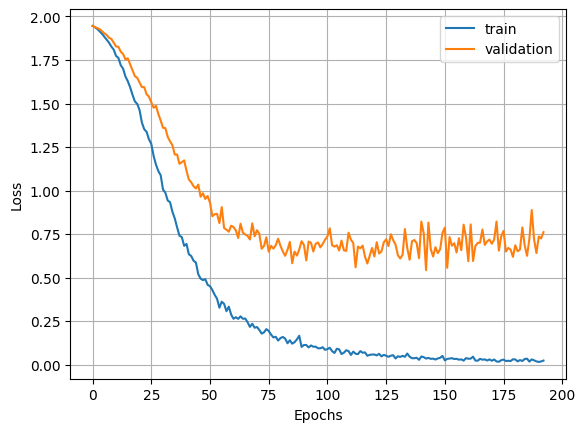

In [16]:
trace_train, trace_val = train(three_layer_gcn, X, A, labels, idx_train, idx_val)

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## 2 - Personalized Propagation of Neural Predictions 

We learned that a GCN comes with several limitations. Some of them are targeted via (Approximate) Personalized Propagation of Neural Predictions (A)PPNP.

We use the iterative approach
$$𝐻^{(𝑙+1)}= (1−\alpha) \delta_{\text{dropout}} \hat{A} 𝐻^{(𝑙)} + \alpha 𝐻^{(0)}$$
to approximate the personalized page rank. $\alpha$ denotes the restart/teleport probability and $𝐻^{(0)}$ the result (i.e. logits) of a feed forward neural network on the input features $𝐻^{(0)}=f_{\theta}(X)$. Looking at the details of [[Klicpera et al. 2019]](https://arxiv.org/abs/1810.05997) we understand that dropout is applied to the approximate propagation step (see upcoming Section 2.2). In each step, a randomly drawn dropout mask $\delta_{\text{dropout}}$ is multiplied with the normalized adjacency matrix $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$.

### 2.2 - Approximate Personalized Pagerank 

Implement the power iteration for approximating the personalized page rank (`PowerIterationPageRank` in `task.py`).

### 2.3 - Approximate Personalized Propagation of Neural Predictions 

Put it all together in `APPNP` in `task.py` (note that we only subclass `GCN` for access to `self._normalize(...)`).

In [17]:
three_layer_appnp = APPNP(n_features=D, n_classes=C, hidden_dimensions=[64, 64])
if use_cuda:
    three_layer_appnp = three_layer_appnp.cuda()
    
three_layer_appnp

APPNP(
  (propagate): PowerIterationPageRank()
  (transform_features): Sequential(
    (dropout_0): Dropout(p=0.5, inplace=False)
    (linear_0): Linear(in_features=2879, out_features=64, bias=True)
    (activation_0): ReLU()
    (linear_1): Linear(in_features=64, out_features=64, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=64, out_features=7, bias=True)
    (dropout_2): Dropout(p=0.5, inplace=False)
  )
)

Epoch    0: loss_train: 1.94369, loss_val: 1.94701 
Epoch   10: loss_train: 1.81211, loss_val: 1.87217 
Epoch   20: loss_train: 1.59014, loss_val: 1.76009 
Epoch   30: loss_train: 1.42694, loss_val: 1.57216 
Epoch   40: loss_train: 1.07605, loss_val: 1.51986 
Epoch   50: loss_train: 0.96704, loss_val: 1.21973 
Epoch   60: loss_train: 0.72103, loss_val: 1.14436 
Epoch   70: loss_train: 0.72470, loss_val: 0.98743 
Epoch   80: loss_train: 0.58119, loss_val: 1.01966 
Epoch   90: loss_train: 0.51201, loss_val: 0.98572 
Epoch  100: loss_train: 0.41835, loss_val: 0.87141 
Epoch  110: loss_train: 0.43080, loss_val: 1.25937 
Epoch  120: loss_train: 0.36360, loss_val: 0.96145 
Epoch  130: loss_train: 0.40832, loss_val: 1.14532 
Epoch  140: loss_train: 0.40481, loss_val: 0.96584 
Epoch  150: loss_train: 0.24394, loss_val: 0.87042 
Epoch  160: loss_train: 0.24443, loss_val: 0.93495 
Epoch  170: loss_train: 0.26092, loss_val: 1.26848 
Epoch  180: loss_train: 0.29014, loss_val: 0.94619 
Epoch  190: 

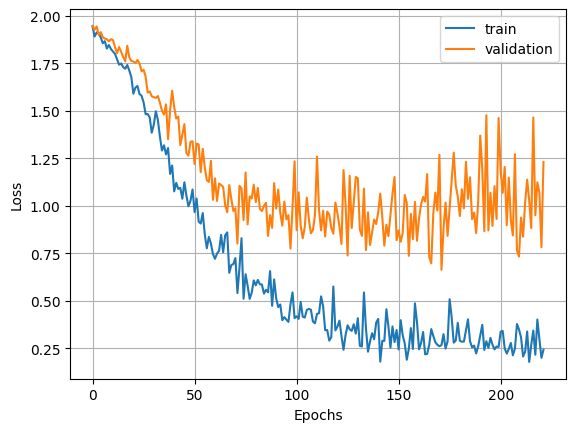

In [18]:
trace_train, trace_val = train(three_layer_appnp, X, A, labels, idx_train, idx_val)

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## 3 - Oversmoothing
As we have learned, we should limit the number of message passing steps for a vanilla GCN to prevent oversmoothing. In this section, we are going to analyze this phenomenon via plotting the test accuracy over the number of propagation steps.

## 3.1 - Accuracy 
Implement `calc_accuracy` in `task.py`.
Please note that you are given the logits (no softmax applied), the labels, and the indices of the test nodes.

## 3.2 - Compare GCN and APPNP 

Calculate the accuracy (keep in mind that dropout is only applied during training). Subsequently, we plot the accuracies over the numer of propagation steps.

In [19]:
n_hidden_dimensions = 64
n_propagations = [1,2,3,4,5,10]

test_accuracy_gcn = []
for n_propagation in n_propagations:
    model = GCN(n_features=D, n_classes=C, hidden_dimensions=n_propagation*[n_hidden_dimensions])
    if use_cuda:
        model = model.cuda()
    train(model, X, A, labels, idx_train, idx_val, display_step=-1)
    ##########################################################
    # YOUR CODE HERE
    logits = model(X, A)
    accuracy = calc_accuracy(logits, labels, idx_test)
    ##########################################################
    test_accuracy_gcn.append(accuracy)
    
test_accuracy_appnp = []
for n_propagation in n_propagations:
    model = APPNP(n_features=D, n_classes=C, n_propagation=n_propagation)
    if use_cuda:
        model = model.cuda()
    train(model, X, A, labels, idx_train, idx_val, display_step=-1)
    ##########################################################
    # YOUR CODE HERE
    logits = model(X, A)
    accuracy = calc_accuracy(logits, labels, idx_test)
    ##########################################################
    test_accuracy_appnp.append(accuracy)

NameError: name 'accuracy' is not defined

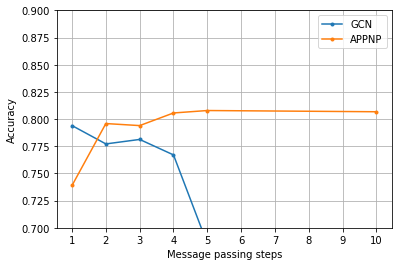

In [ ]:
plt.plot(n_propagations, test_accuracy_gcn, label='GCN', marker='.')
plt.plot(n_propagations, test_accuracy_appnp, label='APPNP', marker='.')
plt.xlabel('Message passing steps')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend()
plt.grid(True)